In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [49]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
import numpy as np

In [50]:
#한글 깨짐 방지
from matplotlib import rc, font_manager
font_path='../data/fonts/malgun.ttf'
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font_name)
#마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus']=False

In [51]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(125)
if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [52]:
# 데이터 불러오기
pred_product=pd.read_csv('../data/merge/pred_values.csv')

pred_product['date'] = pd.to_datetime(pred_product['date'], format='%Y-%m-%d')

# 'date' 열을 인덱스로 설정
pred_product.set_index('date', inplace=True)

pred_product.info()
pred_product

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2023-01-01 to 2024-12-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   수온(30m)    24 non-null     float64
 1   수온(50m)    24 non-null     float64
 2   염분(30m)    24 non-null     float64
 3   염분(50m)    24 non-null     float64
 4   용존산소(30m)  24 non-null     float64
 5   용존산소(50m)  24 non-null     float64
dtypes: float64(6)
memory usage: 1.3 KB


,수온(30m),수온(50m),염분(30m),염분(50m),용존산소(30m),용존산소(50m)
date,,,,,,
2023-01-01,14.511343,14.561705,34.540796,34.336701,5.625323,5.082781
2023-02-01,14.040472,13.308127,34.543689,34.511686,6.074028,5.152043
2023-03-01,15.218406,14.554814,34.482914,34.502973,6.006842,5.477194
2023-04-01,15.915558,15.956488,34.289275,34.488197,6.054815,5.771078
2023-05-01,16.578329,15.845456,34.124423,34.252513,5.781481,5.321406
2023-06-01,17.507408,15.717723,33.743774,34.017331,5.625675,4.961934
2023-07-01,18.548673,16.495215,33.186334,33.947309,5.140363,4.665273
2023-08-01,19.038191,17.185116,33.240597,33.886977,4.928251,4.311524
2023-09-01,19.747150,19.769593,33.440614,33.697720,4.924120,4.321857


In [59]:
seq_length=3 # 3~7사이 값 설정
data_dim=7
hidden_dim=14
output_dim=1

In [54]:
#input scale
scaler_x=MinMaxScaler()
scaler_x.fit(pred_product)

pred_product=scaler_x.transform(pred_product)

In [55]:
class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_length, output_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim=hidden_dim
    self.seq_length=seq_length
    self.output_dim=output_dim
    self.layers=layers

    self.lstm=nn.LSTM(input_dim, 
                      hidden_dim, 
                      num_layers=layers,
                      batch_first=True)
    
    self.fc=nn.Linear(hidden_dim, output_dim, bias=True)

  def reset_hidden_state(self):
    self.hidden=(
      torch.zeros(self.layers, self.seq_length, self.hidden_dim),
      torch.zeros(self.layers, self.seq_length, self.hidden_dim)
    )
  def forward(self, x):
    x, _status=self.lstm(x)
    x=self.fc(x[:, -1])
    return x

In [56]:
def build_dataset(time_series, seq_length):
    dataX=[]
    dataY=[]
    for i in range(0, len(time_series)-seq_length):
        x_=time_series[i:i+seq_length, :]
        dataX.append(x_)
    return np.array(dataX)

In [63]:
predX=build_dataset(np.array(pred_product),seq_length)
predX.shape

(21, 3, 6)

In [65]:
predX_tensor=torch.FloatTensor(predX)

In [61]:
path="../model/product_final.pth"
model=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(path), strict=False)
model.eval()

Net(
  (lstm): LSTM(7, 14, batch_first=True)
  (fc): Linear(in_features=14, out_features=1, bias=True)
)

In [71]:

with torch.no_grad():
    pred=[]
    for pr in range(len(predX_tensor)):
        model.reset_hidden_state()
        predicted=model(torch.unsqueeze(predX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse=scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))


print('MAe SCORE:', MAE(pred_inverse, testY_inverse))

TypeError: object of type 'float' has no len()

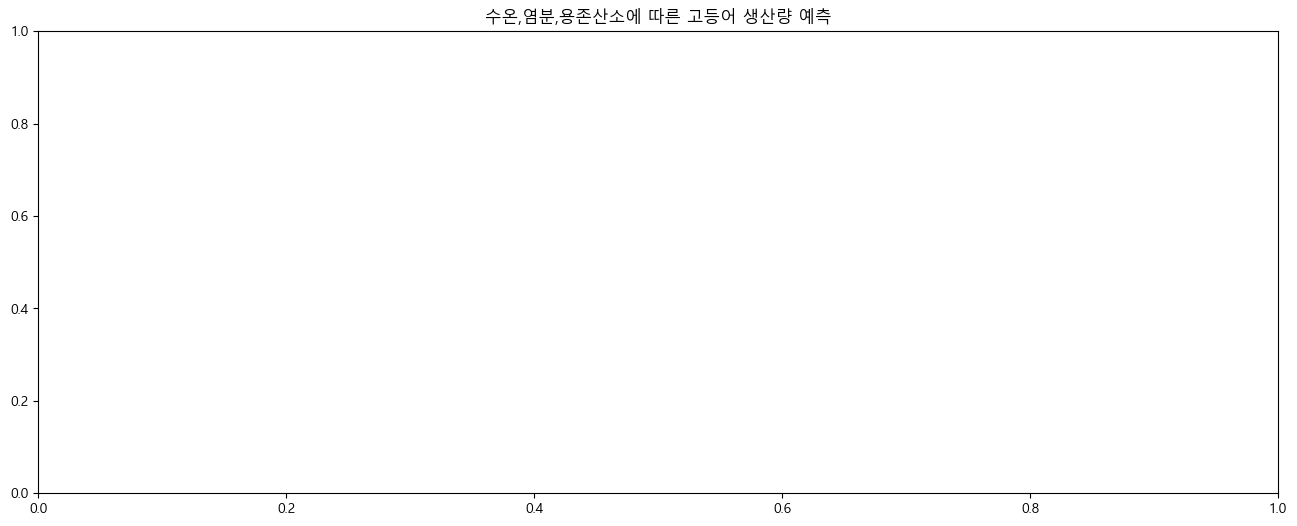